# Статистический анализ данных сервиса проката самокатов GoFast

**Описание проекта:** Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.

**Цель проекта:** Определение различий между пользователями с подпиской и без нее для составления рекомендаций сервису по прокату самокатов для увеличения выручки.

**Ход исследования:**
1. Подготовка данных - загрузка и изучение общей информации из предоставленных датасетов.
2. Предобработка данных - поиск пропущенных значений, дубликатов, корректировка типов данных.
3. Расширение набора данных - добавление новых столбцов, таких как номер месяца, помесячная выручка за каждого пользователя по месяцам.
4. Исследовательский анализ данных - изучение распределений пользователей по городам, по возрасту, наличию подписки, проезжаемому расстоянию и затраченному времени.
5. Проверка гипотез - проверка гипотез о том тратят ли пользователи с подпиской больше времени на поездки, проезжают ли больше оптимального расстояния для самоката и приносят ли такие пользователи сервису больше выручки, чем пользователи без подписки.

**Общий вывод:** рекомендации сервису по увеличению выручки.

In [1]:
#импорт библиотек
import pandas as pd 
import numpy as np 
from scipy import stats as st
from matplotlib import pyplot as plt 
from math import sqrt 
import seaborn as sns

## Обзор данных

In [2]:
user_go = pd.read_csv('./users_go.csv') #загрузка датафрейма с данными о пользователях
rides_go = pd.read_csv('./rides_go.csv', parse_dates=['date']) #загрузка датафрейма с данными о поездках
subscription_go = pd.read_csv('./subscriptions_go.csv') #загрузка датафрейма с данными о подписках

In [3]:
user_go.info()
user_go.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides_go.info()
rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscription_go.info()
subscription_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- пропусков нет ни в одной таблице
- все столбцы кроме `date` из таблицы `rides_go` имеют нужные типы данных
- названия столбцов записаны корректно.

## Предобработка данных

### Округление значений в столбце duration датафрейма subscription_go

In [6]:
rides_go['duration'] = np.ceil(rides_go['duration']) 

### Создание столбца с номером месяца в датафрейме rides_go

In [7]:
rides_go['month'] = rides_go['date'].dt.month #создание столбца с номером месяца поездки

### Дубликаты

In [8]:
user_go.duplicated().sum() #поиск явных дубликатов в датафрейме user_go

31

In [9]:
user_go = user_go.drop_duplicates().reset_index(drop=True) #удаление явных дубликатов в датафрейме user_go

In [10]:
rides_go.duplicated().sum() #поиск явных дубликатов в датафрейме rides_go

0

In [11]:
subscription_go.duplicated().sum() #поиск явных дубликатов в датафрейме subscription_go

0

Явные дубликаты были найдены и удалены только в датафрейме user_go. В остальных датафреймах дубликатов обнаружено не было.

Таким образом, на этапе обработки данных были округлены значения в столбце duration датасета rides_go, создан новый столбец с номером месяца. Все датасеты проверены на наличие явных дубликатов. Явные дубликаты удалены из датасета user_go.

## Исследовательский анализ данных

### Частота встречаемости городов

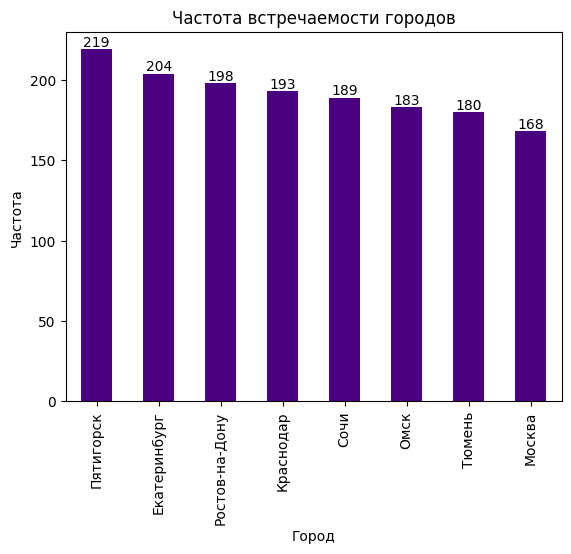

In [12]:
ax = user_go['city'].value_counts().plot(kind='bar', 
                                         title='Частота встречаемости городов', 
                                         ylabel='Частота', 
                                         xlabel='Город',
                                         color = 'Indigo')
ax.bar_label(ax.containers[0], fontsize=10);

Наибольшее число пользователей приложения обитает в Пятигорске - 219 человек, наименьшее - в Москве - 168 человек.

### Соотношение числа пользователей с подпиской и без

In [13]:
user_free = (user_go.query('subscription_type == "free"').count()['user_id']) / (user_go.shape[0]) #расчет количества пользователей без подписки
print('Доля пользователей без подписки:', round(user_free, 3)) #вывод доли пользователей без подписки 
print('Доля пользователей с подпиской:', round(1 - user_free, 3)) #вывод пользователей с подпиской

Доля пользователей без подписки: 0.544
Доля пользователей с подпиской: 0.456


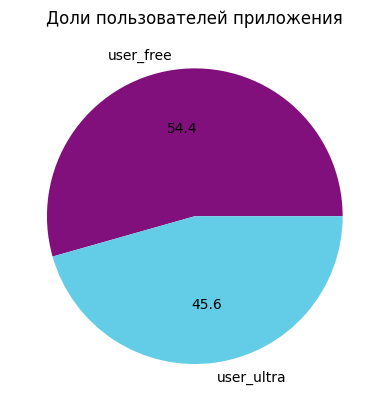

In [14]:
user_fraction = [round(user_free, 3), round(1 - user_free, 3)] #создание списка с долями пользователей
names = ['user_free', 'user_ultra'] #список подписей к частям "пирога"
colors = ['#810f7c', '#63cde8']
plt.title("Доли пользователей приложения") #заголовок графика
plt.pie(user_fraction, labels=names, autopct='%.1f', colors=colors); #вывод графика

Доля пользователей с подпиской составляет около 46% - это чуть меньше, чем половина пользователей приложения.

### Возраст пользователей

In [15]:
def graph_hist(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца {column}')
    plt.ylabel('Частота')
    plt.title(f'Распределение столбца {column}')
    sns.histplot(data[column], color='MediumPurple', bins=20)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Распределение столбца {column}')
    sns.boxplot(x=data[column], color='Indigo')

In [16]:
user_go['age'].sort_values().unique() #уникальные значения возраста пользователей

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43])

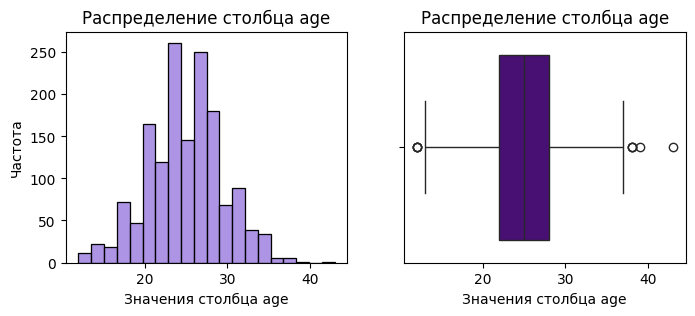

In [17]:
graph_hist(user_go, 'age')

Возраст пользователей составляет от 12 до 43 лет. Распределение пользователей по возрасту близко к нормальному распределению со средним возрастом около 24-25 лет. Число пользователeй после 35 лет очень невелико.

### Расстояние за одну поездку

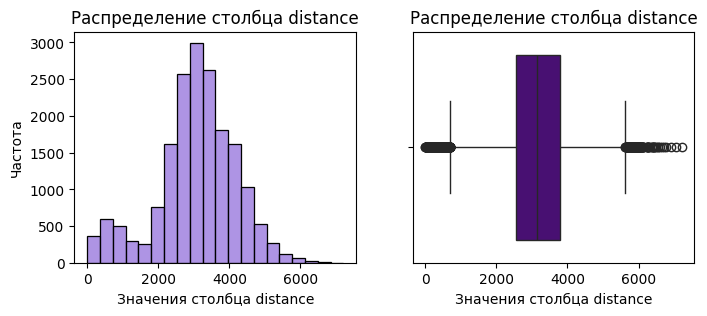

In [18]:
graph_hist(rides_go, 'distance')

In [19]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Распределение расстояний за одну поездку близится к нормальному. Наблюдается проседание частот в области 1000-2000 м. Если посмотреть на график boxplot, то можно увидеть, что есть аномально коротки и аномально длинные поездки. Среднее (медианное) расстояние поездки составляет около 3100 м.

### Продолжительность поездок

In [20]:
rides_go['duration'].sort_values().unique() #уникальные значения продолжительности поездок

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41.])

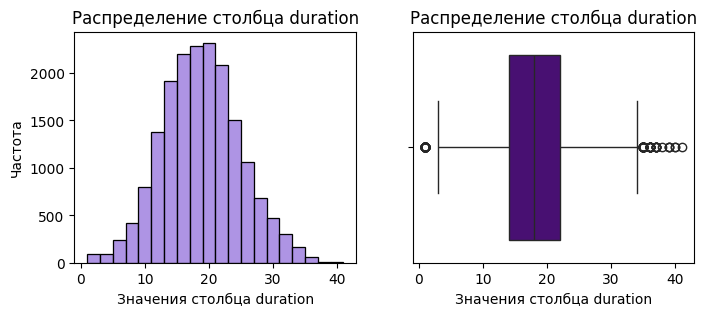

In [21]:
graph_hist(rides_go, 'duration')

Распределение продолжительности представляет собой нормальное распределение со средней продолжительностью около 17 минут. По графику boxplot видно, что есть аномально короткие поездки продолжительностью 0,5 минуты, далее уже встречаются поездки от 2 минут. Возможно это поездки, когда пользователь решил поехать, взял самокат в аренду и тут же передумал, и для таких поездок ставится значение по умолчанию равное 30 секундам?

## Объединение данных

In [22]:
print('Количество строк датасета user_go:', user_go.shape[0])
print('Количество строк датасета rides_go:', rides_go.shape[0])
print('Количество строк датасета subscription_go:', subscription_go.shape[0])

Количество строк датасета user_go: 1534
Количество строк датасета rides_go: 18068
Количество строк датасета subscription_go: 2


In [23]:
user_rides = user_go.merge(rides_go, on='user_id') #объединение user_go и rides_go
print('Количество строк датасета user_rides:', user_rides.shape[0]) #проверка размера объединенного датасета
data = user_rides.merge(subscription_go, on='subscription_type') #объединение с subscription_go
print('Количество строк датасета data:', data.shape[0]) #проверка размера объединенного датасета
data.isna().sum() #проверка полученного датасета на пропуски

Количество строк датасета user_rides: 18068
Количество строк датасета data: 18068


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

После объединения всех датасетов размер объединенного датасата равен размеру самого большого датасета - rides_go. Пропусков в полученном датасете не обнаружено.

In [24]:
data_free = data.query('subscription_type == "free"') #создание датафрейма пользователей без подписки

In [25]:
data_ultra = data.query('subscription_type == "ultra"') #создание датафрейма пользователей с подпиской

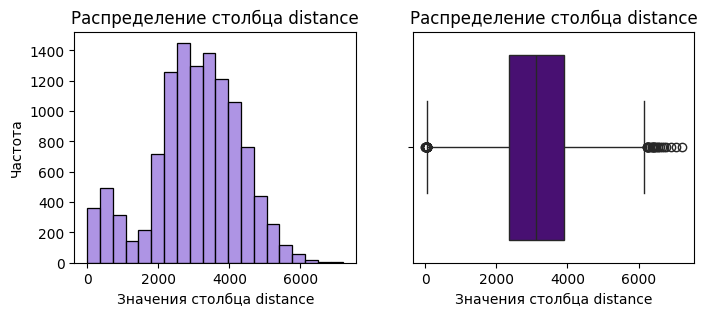

In [26]:
graph_hist(data_free, 'distance')

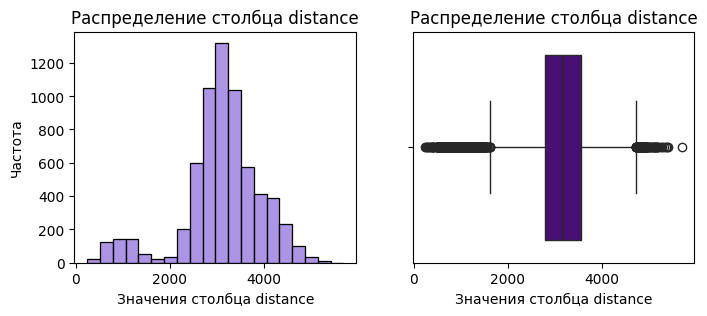

In [27]:
graph_hist(data_ultra, 'distance')

Распределения расстояний для пользователей обеих групп схожи между собой.

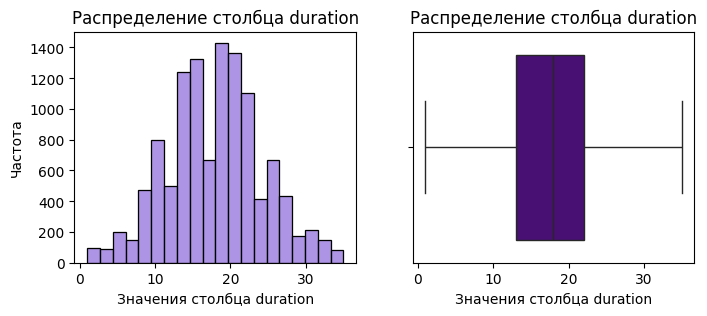

In [28]:
graph_hist(data_free, 'duration')

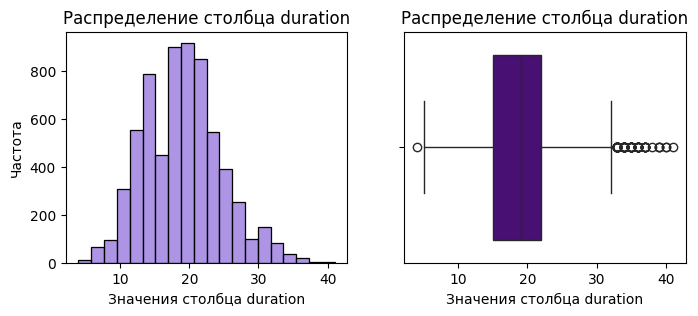

In [29]:
graph_hist(data_ultra, 'duration')

Ранее выявленные аномально короткие поездки по 30 секунд относятся только к пользователям без подписки. Распределение продолжительности поездки представляет собой нормальное распределение для обоих групп пользователей. Средняя продолжительность поездки у пользователей с подпиской и без составляет около 17 минут. 

## Подсчёт выручки

In [30]:
#создание агрегированного по месяцам датафрейма с общим длительностью, числом поездок 
#и общим временем поездок для каждого пользователя без подписки
data_month_free = data_free.groupby(['month', 'user_id']).agg({'distance':'sum', 
                                                     'city':'count', 
                                                     'duration':'sum', 
                                                     'minute_price':'mean', 
                                                     'start_ride_price':'mean', 
                                                     'subscription_fee':'mean'}) 
data_month_free['subscription_type'] = 'free'
data_month_free.columns = data_month_free.columns.str.replace('city', 'rides_number') #переименование столбца с количеством поездок

#создание столбца с помесячной выручкой для каждого пользователя
data_month_free['revenue'] = data_month_free['start_ride_price'] * data_month_free['rides_number'] + data_month_free['minute_price'] * data_month_free['duration'] + data_month_free['subscription_fee']
data_month_free

distance  rides_number  duration  minute_price  \
month user_id                                                      
1     700      2515.690719             1      15.0           8.0   
      701      2676.472894             1      18.0           8.0   
      702       903.861985             1      16.0           8.0   
      703      3406.580225             1      24.0           8.0   
      704      3197.139639             1      18.0           8.0   
...                    ...           ...       ...           ...   
12    1525     4597.854350             1      34.0           8.0   
      1526     3644.121544             1      23.0           8.0   
      1528     3998.569324             1      11.0           8.0   
      1532     6111.889853             2      42.0           8.0   
      1534     2371.711192             1      16.0           8.0   

               start_ride_price  subscription_fee subscription_type  revenue  
month user_id                                                                 
1     700                  50.0               0.0              free    170.0  
      701                  50.0               0.0              free    194.0  
      702                  50.0               0.0              free    178.0  
      703                  50.0               0.0              free    242.0  
      704                  50.0               0.0              free    194.0  
...                         ...               ...               ...      ...  
12    1525                 50.0               0.0              free    322.0  
      1526                 50.0               0.0              free    234.0  
      1528                 50.0               0.0              free    138.0  
      1532                 50.0               0.0              free    436.0  
      1534                 50.0               0.0              free    178.0  

[6798 rows x 8 columns]

In [31]:
#создание агрегированного по месяцам датафрейма с общим длительностью, числом поездок 
#и общим временем поездок для каждого пользователя с подпиской 
data_month_ultra = data_ultra.groupby(['month', 'user_id']).agg({'distance':'sum', 
                                                     'city':'count', 
                                                     'duration':'sum', 
                                                     'minute_price':'mean', 
                                                     'start_ride_price':'mean', 
                                                     'subscription_fee':'mean'}) 
data_month_ultra['subscription_type'] = 'ultra'
data_month_ultra.columns = data_month_ultra.columns.str.replace('city', 'rides_number') #переименование столбца с количеством поездок

#создание столбца с помесячной выручкой для каждого пользователя
data_month_ultra['revenue'] = data_month_ultra['start_ride_price'] * data_month_ultra['rides_number'] + data_month_ultra['minute_price'] * data_month_ultra['duration'] + data_month_ultra['subscription_fee']
data_month_ultra

distance  rides_number  duration  minute_price  \
month user_id                                                      
1     1        7027.511294             2      42.0           6.0   
      3        3061.777147             1      13.0           6.0   
      5        3914.646990             1      13.0           6.0   
      7        6478.080979             2      28.0           6.0   
      12       3577.151148             1      33.0           6.0   
...                    ...           ...       ...           ...   
12    688      4004.404223             1      24.0           6.0   
      689      3387.343067             1      19.0           6.0   
      692      2947.000211             1      15.0           6.0   
      694      3591.099488             1      18.0           6.0   
      699      3202.890770             1      26.0           6.0   

               start_ride_price  subscription_fee subscription_type  revenue  
month user_id                                                                 
1     1                     0.0             199.0             ultra    451.0  
      3                     0.0             199.0             ultra    277.0  
      5                     0.0             199.0             ultra    277.0  
      7                     0.0             199.0             ultra    367.0  
      12                    0.0             199.0             ultra    397.0  
...                         ...               ...               ...      ...  
12    688                   0.0             199.0             ultra    343.0  
      689                   0.0             199.0             ultra    313.0  
      692                   0.0             199.0             ultra    289.0  
      694                   0.0             199.0             ultra    307.0  
      699                   0.0             199.0             ultra    355.0  

[4533 rows x 8 columns]

## Проверка гипотез

### Длительность поездок пользователей с подпиской и без

Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Сформулируем нулевую гипотезу Н0: средняя продолжительность поездки у пользователей без подписки равняется средней продолжительности поездки у пользователей с подпиской.

Альтернативная гипотеза будет выглядеть следующим образом: средняя продолжительность поездки у пользователей с подпиской больше, чем у пользователей без подписки (правосторонняя гипотеза Н1).

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам будем использовать метод st.ttest_ind(array1, array2, equal_var, alternative), поскольку данные выборки являются независимыми.

In [32]:
#проверка гипотезы о равенстве средней продолжительности поездки для пользователей с подпиской и без
alpha = 0.05 #уровень значимости 

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater') #расчет p_value

print('Среднее время поездки для пользователей без подписки:', round(data_free['duration'].mean(), 2))
print('Среднее время поездки для пользователей с подпиской:', round(data_ultra['duration'].mean(), 2))
print('p-значение:', results.pvalue)

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее время поездки для пользователей без подписки: 17.89
Среднее время поездки для пользователей с подпиской: 19.04
p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Отвергая нулевую гипотезу, мы действительно можем предположить, что пользователи с подпиской тратят больше времени на поездки.

### Оптимальное расстояние поездки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза Н0: среднее расстояние поездки пользователей с подпиской равняется 3130 метров.

Альтернативная гипотеза Н1 (правосторонняя): среднее расстояние поездки пользователей с подпиской больше 3130 метров.

In [33]:
#проверка гипотезы о равенстве среднего расстояния поездки для пользователей с подпиской с 3130 метрами
alpha = 0.05 
optimal_distance = 3130

results = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')

print('Среднее расстояние поездки для пользователей с подпиской:', round(data_ultra['distance'].mean(), 2))
print('p-значение:', results.pvalue)

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее расстояние поездки для пользователей с подпиской: 3115.45
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Можно предположить, что среднее расстояние поездки, проезжаемое пользователями с подпиской не превосходит оптимального значения в 3130. За сохранность самокатов можно быть спокойным :)

### Помесячная выручка

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза Н0: помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки

Альтернативная гипотеза Н1 (правосторонняя): помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.

In [34]:
#проверка гипотезы о равенстве средней помесячной выручки для пользователей с подпиской и без
alpha = 0.05 #уровень значимости 

results = st.ttest_ind(data_month_ultra['revenue'], data_month_free['revenue'], alternative='greater') #расчет p_value

print('Средняя помесячная выручка для пользователей без подписки:', round(data_month_free['revenue'].mean(), 2))
print('Средняя помесячная выручка для пользователей с подпиской:', round(data_month_ultra['revenue'].mean(), 2))
print('p-значение:', results.pvalue)

if results.pvalue < alpha: #проверка p_value
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средняя помесячная выручка для пользователей без подписки: 328.64
Средняя помесячная выручка для пользователей с подпиской: 362.79
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза опровергнута. Можно предположить, что помесячная выручка с пользователей с подпиской больше, чем от пользователей без подписки. Надо больше подписок :)

### Техподдержка
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Необходимо было бы воспользоваться методом scipy.stats.ttest_rel(), который используется для парных генеральных совокупностей. Нулевая гипотеза будет про равенство обращений до и после обновления серверов. Альтернативная - после обновления обращений стало меньше - левосторонняя гипотеза.

## Распределения

### Раздача промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

100.22187899952792


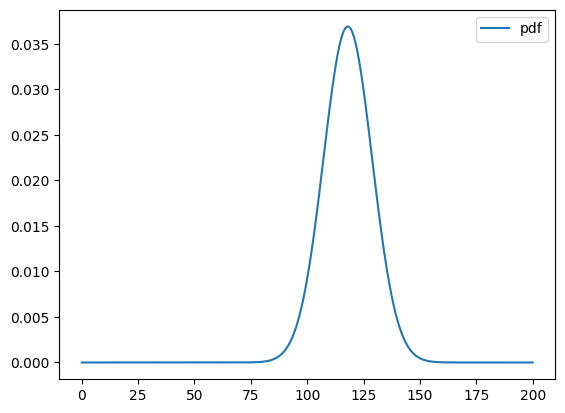

In [35]:
#параметры биномиального распределения
n = 11800
p = 0.01

#параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) #нормальное распределение

result = distr.ppf(0.05)
print(result)

x = np.linspace(0, 200, 5000)

y_pdf = st.norm.pdf(x, mu, sigma)

plt.plot(x, y_pdf, label='pdf')
plt.legend();

Нужно разослать как минимум 11800 промокодов, чтобы со 95% вероятностью как минимум 100 клиентов продлило подписку.

### Рассылка push-уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

0.15371708296369768


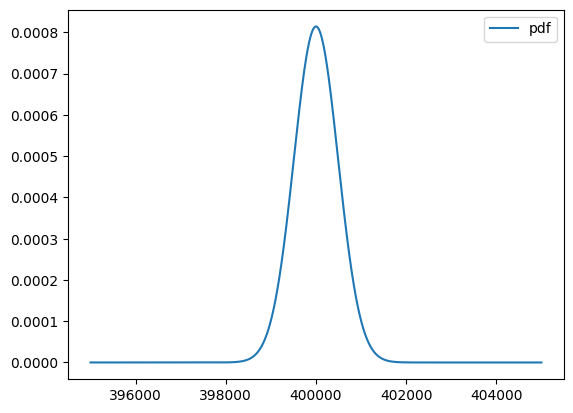

In [36]:
#параметры биномиального распределения
n = 1000000
p = 0.4

#параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) #нормальное распределение

result = distr.cdf(399500)
print(result)

x = np.linspace(395000, 405000, 5000)

y_pdf = st.norm.pdf(x, mu, sigma)

plt.plot(x, y_pdf, label='pdf')
plt.legend();

Вероятность, что уведомление откроют не более 399,5 тысяч пользователей составляет около 15%. 

## Вывод

В данном проекте были проанализированны данные о пользователях сервиса проката самокатов GoFast. Целью проекта было определение различий между группами пользователей с подпиской и без подписки на приложение. 
Данные были предоставлены в трех файлах:

Пользователи — users_go.csv:
1. user_id - уникальный идентификатор пользователя
2. name - имя пользователя
3. age	- возраст
4. city	- город
5. subscription_type - тип подписки (free, ultra)

Поездки — rides_go.csv:
1. user_id - уникальный идентификатор пользователя
2. distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
3. duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
4. date - дата совершения поездки


Подписки — subscriptions_go.csv:
1. subscription_type - тип подписки
2. minute_price - стоимость одной минуты поездки по данной подписке
3. start_ride_price - стоимость начала поездки
4. subscription_fee - стоимость ежемесячного платежа

Предварительно данные были подготовлены, а затем проанализированы:
1. В столбце date датафрейма rides_go тип данных был изменен для дальнейшей работы с датой (определение месяца поездки).
2. Создан новый столбец с номером месяца.
3. Все столбцы были проверены на наличие пропущенных значений, а также явных дубликатов. Из датафрейма user_go были удалены явные дубликаты.
4. Данные были проанализированы по частоте встречаемости городов - наибольшее количество поездок было совершено в Пятигорске, наименьшее в Москве. Более половины пользователей (54,4%) - это пользователи без подписки. Возраст пользователей составляет от 12 до 43 лет. Основную возрастную категорию составляют пользователи от 20 до 30 лет.
5. Данные были разделены на 2 таблицы - пользователи с подпиской  и без подписки. Для каждой из групп было рассчитана помесячная выручка для каждого пользователя.

По итогу было проверено 3 гипотезы:
1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Оказалось, что пользователи с подпиской действительно тратят больше времени на поездки. Поэтому предложение оформления подписки может увеличить продолжительность поездок.
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Пользователи с подпиской обычно проезжают расстояние меньше оптимального для самоката. Пользователям с подпиской можно доверить сохранность самоката.
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? Оказалось, что помесячная выручка с пользователей с подпиской больше, чем от пользователей без подписки. Значит, предлагать подписки всё-таки стоит. 

Таким образом, необходимо рассмотреть способы привлечения пользователей к оформлению подписки, поскольку это позволит увеличить помесячную выручку. 